## Train the MPNN Classifier

In this Section we train a simple MPNN classifier which is composed of a variable number of custom MPNN layers which also take edge features into account and a simple MLPNN with three linear layers that gradually reduces the output size to $2$ in the final layer to give the classification probabilities for our binary classification task. We use `Relu()` as non-linearities and add a dropout layer inbetween the linear layers.

For the MPNN layers we optimize over the remaining hyperparameters. We also aggregate the node representation to a graph representation for graph classification after the MPNN layers via a `global_add_pool` and a `global_mean_pool`, concatenate both and pass them on to the classifier.

The model is defined in `models.py`.

In this notebook we perform a hyperparameter sweep and choose the best model according to accuracy, balanced accuracy (due to the class imbalance) and AUC. We then train the best model and use it to classify the test set.

We use 10-fold stratified cross-validation for steps 1 and 2.

---

## Notebook Contents
1. [**Hyperparameter Scan**](#scan): Scan through a range of hyperparameters and find best model.
2. [**Benchmark Best Model**](#explore): Train best model and get statistical information.
3. [**Evaluate Test Set**](#test): Evaluate model on test set

---

Load relevant modules

In [ ]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch_geometric
import random
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc,
    mean_absolute_error, mean_squared_error, r2_score, precision_recall_curve, balanced_accuracy_score
)

from sklearn.preprocessing import label_binarize

from sklearn.model_selection import StratifiedKFold

from dataset import Tox21Dataset, random_split_dataset
from trainer import Trainer
import os

Set random seeds to make results reproducible (see https://docs.pytorch.org/docs/stable/notes/randomness.html)

In [3]:
rnd_seed=1

random.seed(rnd_seed)
np.random.seed(rnd_seed)
torch.manual_seed(rnd_seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(rnd_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark     = False

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(rnd_seed)

Load dataset and split it into train and test set (90% - 10%)

In [4]:
root_dir = os.path.join(os.getcwd(),'data_1')
ds = Tox21Dataset(root=root_dir, task=['NR-AhR'])
train_set, _ , test_set = random_split_dataset(ds, frac_train=0.9, frac_val=0.0, frac_test=0.1)

skf = StratifiedKFold(n_splits=10)

## 1. Hyperparameter Scan
<a id='scan'></a>

We now scan over the following hyperparameters:
- dropout in [0.2, 0.4, 0.6]
- number of GAT layers in [2, 3, 4]
- feature dimension in hidden layers [32, 64]
- learing rate in [5e-3, 1e-3, 5e-4]

We use 10-fold startified cross-validation to get a statistically meaningful comparison. For each fold we keep the batch size fixed to 64 and train the network for 50 epochs and save the validation accuracy, balanced accuracy and AUC to compare all models.

In [5]:
from models import MPNNModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 64

dropout_list = [0.2, 0.4, 0.6]
num_layer_list = [2, 3, 4]
num_hidden_list = [32, 64]
lr_list = [5e-3, 1e-3, 5e-4]
model_summary = []
train_class_label = np.array([0 if e==[1,0] else 1 for e in train_set.y.view(-1,2)])

for do in dropout_list:
    for num_l in num_layer_list:
        for num_h in num_hidden_list:
            for lr in lr_list:
                acc_list = []
                auc_list = []
                bal_acc_list = []
                print(f'Model with num_hidden={num_h}, num_layer={num_l}, lr={lr:.4f}, dropout={do:.4f}')

                for i, (train_index, test_index) in enumerate(skf.split(np.zeros(len(train_class_label)), train_class_label)):
                    trainfold = train_set[train_index]
                    valfold = train_set[test_index]
                    train_sampler = ImbalancedSampler(torch.tensor([0 if e==[1,0] else 1 for e in trainfold.y.view(-1,2)], dtype=torch.long))
                    train_dataloader = DataLoader(trainfold, batch_size=batch_size, sampler=train_sampler, drop_last=True, worker_init_fn=seed_worker,generator=g)
                    val_dataloader = DataLoader(valfold, batch_size=batch_size, shuffle=True, drop_last=True, worker_init_fn=seed_worker,generator=g)

                    model = MPNNModel(node_dim=trainfold[0].x.size(1), edge_dim=trainfold[0].edge_attr.size(1), hidden_dim=num_h, num_layers=num_l, dropout=do).to(device)

                    trainer = Trainer(model=model,
                                      train_loader=train_dataloader,
                                      val_loader=val_dataloader,
                                      test_loader=None,
                                      device=device,
                                      save_dir=None,)
                    
                    train_params = {'num_epochs': 50,
                                    'num_early_stop': 0,
                                    'step': 20,
                                    'gamma': 0.5}
                    
                    optimizer_params = {'lr': lr,
                                        'weight_decay': 1e-5}
                    
                    eval_acc, eval_auc, eval_bal_acc = trainer.train(train_params=train_params, optimizer_params=optimizer_params, verbose=False,)
                    acc_list.append(eval_acc)
                    auc_list.append(eval_auc)
                    bal_acc_list.append(eval_bal_acc)
                
                model_summary.append({'num_layer': num_l,
                                      'num_hidden': num_h,
                                      'dropout': do,
                                      'lr': lr,
                                      'mean_acc': np.mean(acc_list),
                                      'std_acc': np.std(acc_list),
                                      'mean_auc': np.mean(auc_list),
                                      'std_auc': np.std(auc_list),
                                      'mean_bal_acc': np.mean(bal_acc_list),
                                      'std_bal_acc': np.std(bal_acc_list)})
                
                print(f'Model with num_hidden={num_h}, num_layer={num_l}, lr={lr:.4f}, dropout={do:.4f}: accuracy={np.mean(acc_list):.4f}±{np.std(acc_list):.4f}, balanced accuracy={np.mean(bal_acc_list):.4f}±{np.std(bal_acc_list):.4f}, AUC={np.mean(auc_list):.4f}±{np.std(auc_list):.4f}')
                    


Model with num_hidden=32, num_layer=2, lr=0.0050, dropout=0.2000
Epoch 50: Training_loss:0.2201, Training_acc:0.9101, Training_auc:0.9115, Training_bal_acc:0.7045, Eval_loss:0.2314, Eval_acc:0.9097, Eval_auc:0.8820, Eval_bal_acc:0.6256
Epoch 50: Training_loss:0.2161, Training_acc:0.9129, Training_auc:0.9044, Training_bal_acc:0.7228, Eval_loss:0.2497, Eval_acc:0.8958, Eval_auc:0.8843, Eval_bal_acc:0.6967
Epoch 50: Training_loss:0.2112, Training_acc:0.9154, Training_auc:0.9170, Training_bal_acc:0.7371, Eval_loss:0.3163, Eval_acc:0.8837, Eval_auc:0.8378, Eval_bal_acc:0.6505
Epoch 50: Training_loss:0.2166, Training_acc:0.9093, Training_auc:0.9113, Training_bal_acc:0.7350, Eval_loss:0.2660, Eval_acc:0.8906, Eval_auc:0.8746, Eval_bal_acc:0.6756
Epoch 50: Training_loss:0.2128, Training_acc:0.9165, Training_auc:0.9112, Training_bal_acc:0.7049, Eval_loss:0.2278, Eval_acc:0.9132, Eval_auc:0.9059, Eval_bal_acc:0.7279
Epoch 50: Training_loss:0.2178, Training_acc:0.9104, Training_auc:0.9171, Traini

The results show that the model with 2 layers, feature dimension in the hidden layer of 64, dropout of 0.2 and a learning rate of 0.001 gives the best balanced accuracy, AUC and accuracy.

In [7]:
import pandas as pd

scan_results = pd.DataFrame(model_summary)
scan_results.sort_values("mean_bal_acc", ascending=False)

,num_layer,num_hidden,dropout,lr,mean_acc,std_acc,mean_auc,std_auc,mean_bal_acc,std_bal_acc
4,2,64,0.2,0.0010,0.908160,0.018770,0.889667,0.016234,0.727789,0.032572
10,3,64,0.2,0.0010,0.902257,0.014063,0.881409,0.018464,0.722058,0.045676
40,2,64,0.6,0.0010,0.902604,0.013503,0.888226,0.020467,0.714001,0.027951
22,2,64,0.4,0.0010,0.908333,0.010057,0.890057,0.022671,0.712530,0.048239
11,3,64,0.2,0.0005,0.906250,0.011117,0.891550,0.017560,0.711084,0.044868
29,3,64,0.4,0.0005,0.905035,0.014443,0.888404,0.018235,0.708760,0.040317
34,4,64,0.4,0.0010,0.903646,0.010709,0.883440,0.013469,0.707342,0.028333
47,3,64,0.6,0.0005,0.898611,0.018261,0.885592,0.020688,0.707254,0.032484
1,2,32,0.2,0.0010,0.909201,0.014485,0.886129,0.017640,0.704867,0.032791
25,3,32,0.4,0.0010,0.902257,0.011333,0.886037,0.017932,0.701624,0.036913


In [11]:
scan_results.to_csv(os.path.join(os.getcwd(), "scan_results/MPNN_scan_results.csv"), index=False)

## 2. Benchmark Best Model
<a id='explore'></a>

Now we want to know how well the best model can perform. We use the best hyperparameters from the scan and train for 200 epochs and save the model after the epoch with the best balanced accuracy on the validation set. In order to get a statistically meaningful result we again do this with 10-fold stratified cross-validation.

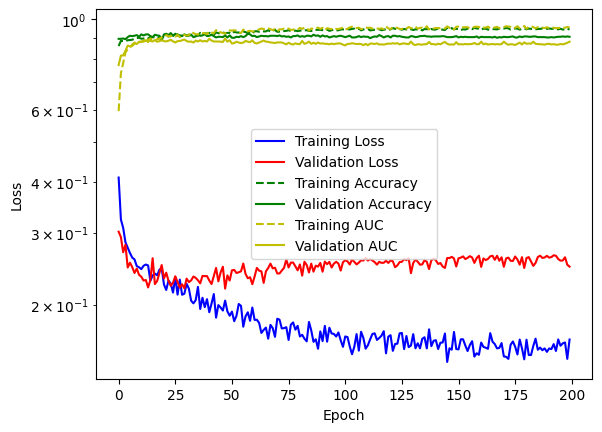

Epoch:0, Training_loss:0.4092, Training_acc:0.8586, Training_auc:0.5949, Training_bal_acc:0.5021, Eval_loss:0.3016, Eval_acc:0.8941, Eval_auc:0.7712, Eval_bal_acc:0.5000
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
Epoch:20, Training_loss:0.2241, Training_acc:0.9082, Training_auc:0.9008, Training_bal_acc:0.6929, Eval_loss:0.2318, Eval_acc:0.9167, Eval_auc:0.8825, Eval_bal_acc:0.6716
Epoch:40, Training_loss:0.1916, Training_acc:0.9247, Training_auc:0.9326, Training_bal_acc:0.7706, Eval_loss:0.2291, Eval_acc:0.9097, Eval_auc:0.8941, Eval_bal_acc:0.6182
Epoch:60, Training_loss:0.1835, Training_acc:0.9329, Training_auc:0.9319, Training_bal_acc:0.7827, Eval_loss:0.2344, Eval_acc:0.9097, Eval_auc:0.8739, Eval_bal_acc:0.6992
Epoch:80, Training_loss:0.1671, Training_acc:0.9362, Training_auc:0.9510, Training_bal_acc:0.8128, Eval_loss:0.2508, Eval_acc:0.9045, Eval_auc:0.8678, Eval_bal_acc:0.6816
Epoch:100, Training_loss:0.1672, Training

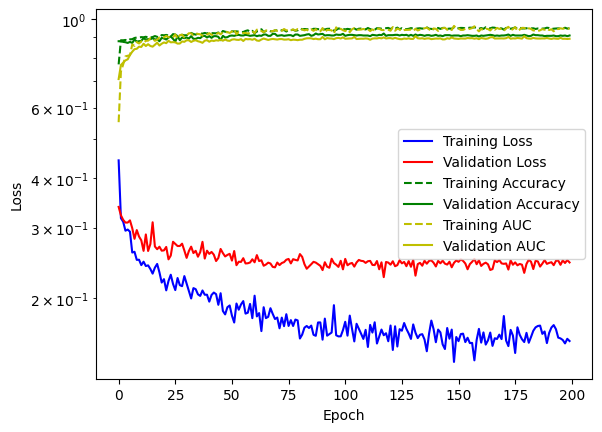

Epoch:0, Training_loss:0.4425, Training_acc:0.7700, Training_auc:0.5516, Training_bal_acc:0.5053, Eval_loss:0.3383, Eval_acc:0.8802, Eval_auc:0.7075, Eval_bal_acc:0.5000
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
Epoch:20, Training_loss:0.2229, Training_acc:0.9106, Training_auc:0.8996, Training_bal_acc:0.6948, Eval_loss:0.2632, Eval_acc:0.8941, Eval_auc:0.8740, Eval_bal_acc:0.6935
saving best...
saving best...
saving best...
Epoch:40, Training_loss:0.1958, Training_acc:0.9251, Training_auc:0.9220, Training_bal_acc:0.7545, Eval_loss:0.2579, Eval_acc:0.9062, Eval_auc:0.8777, Eval_bal_acc:0.6666
Epoch:60, Training_loss:0.2026, Training_acc:0.9215, Training_auc:0.9220, Training_bal_acc:0.7495, Eval_loss:0.2457, Eval_acc:0.9115, Eval_auc:0.8923, Eval_bal_acc:0.7437
saving best...
Epoch:80, Training_loss:0.1583, Training_acc:0.9476, Training_auc:0.9399, Training_bal_acc:0.8001, Eval_loss:0.2576, Eval_acc:0.9080, Eval_auc:0.8878, E

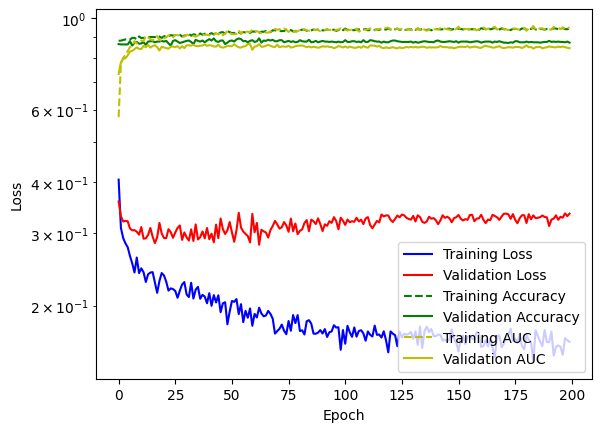

Epoch:0, Training_loss:0.4054, Training_acc:0.8824, Training_auc:0.5754, Training_bal_acc:0.5000, Eval_loss:0.3588, Eval_acc:0.8663, Eval_auc:0.7328, Eval_bal_acc:0.5000
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
Epoch:20, Training_loss:0.2370, Training_acc:0.9049, Training_auc:0.8952, Training_bal_acc:0.7010, Eval_loss:0.2924, Eval_acc:0.8785, Eval_auc:0.8498, Eval_bal_acc:0.6594
saving best...
saving best...
saving best...
Epoch:40, Training_loss:0.2146, Training_acc:0.9162, Training_auc:0.9097, Training_bal_acc:0.7503, Eval_loss:0.2905, Eval_acc:0.8906, Eval_auc:0.8609, Eval_bal_acc:0.6935
saving best...
saving best...
Epoch:60, Training_loss:0.1911, Training_acc:0.9291, Training_auc:0.9284, Training_bal_acc:0.7953, Eval_loss:0.3018, Eval_acc:0.8767, Eval_auc:0.8541, Eval_bal_acc:0.6947
Epoch:80, Training_loss:0.1736, Training_acc:0.9365, Training_auc:0.9386, Training_bal_acc:0.8082, Eval_loss:0.3043, Eval_acc:0.8854, Eval_auc:0.8589, E

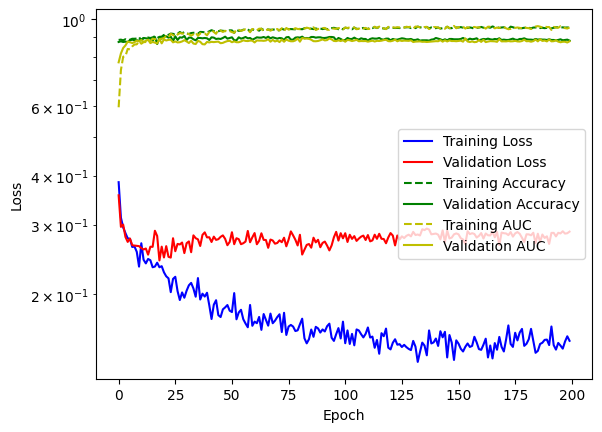

Epoch:0, Training_loss:0.3848, Training_acc:0.8855, Training_auc:0.5968, Training_bal_acc:0.5000, Eval_loss:0.3564, Eval_acc:0.8750, Eval_auc:0.7767, Eval_bal_acc:0.5000
saving best...
saving best...
saving best...
saving best...
saving best...
Epoch:20, Training_loss:0.2269, Training_acc:0.9122, Training_auc:0.8957, Training_bal_acc:0.7025, Eval_loss:0.2475, Eval_acc:0.9080, Eval_auc:0.8879, Eval_bal_acc:0.6873
saving best...
Epoch:40, Training_loss:0.1871, Training_acc:0.9314, Training_auc:0.9272, Training_bal_acc:0.7560, Eval_loss:0.2787, Eval_acc:0.8854, Eval_auc:0.8727, Eval_bal_acc:0.7262
Epoch:60, Training_loss:0.1700, Training_acc:0.9385, Training_auc:0.9428, Training_bal_acc:0.7940, Eval_loss:0.2856, Eval_acc:0.8924, Eval_auc:0.8726, Eval_bal_acc:0.7159
Epoch:80, Training_loss:0.1673, Training_acc:0.9444, Training_auc:0.9435, Training_bal_acc:0.8075, Eval_loss:0.2827, Eval_acc:0.8976, Eval_auc:0.8766, Eval_bal_acc:0.7034
saving best...
Epoch:100, Training_loss:0.1498, Training

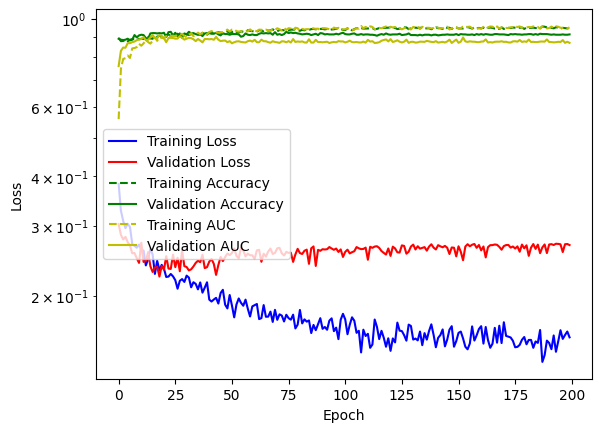

Epoch:0, Training_loss:0.3827, Training_acc:0.8946, Training_auc:0.5578, Training_bal_acc:0.5000, Eval_loss:0.3029, Eval_acc:0.8906, Eval_auc:0.7593, Eval_bal_acc:0.5000
saving best...
saving best...
saving best...
saving best...
saving best...
Epoch:20, Training_loss:0.2338, Training_acc:0.9055, Training_auc:0.8923, Training_bal_acc:0.6859, Eval_loss:0.2324, Eval_acc:0.9219, Eval_auc:0.8948, Eval_bal_acc:0.6987
saving best...
saving best...
Epoch:40, Training_loss:0.1953, Training_acc:0.9232, Training_auc:0.9259, Training_bal_acc:0.7548, Eval_loss:0.2437, Eval_acc:0.9201, Eval_auc:0.8877, Eval_bal_acc:0.8044
saving best...
Epoch:60, Training_loss:0.1891, Training_acc:0.9289, Training_auc:0.9345, Training_bal_acc:0.7918, Eval_loss:0.2476, Eval_acc:0.9097, Eval_auc:0.8850, Eval_bal_acc:0.7545
Epoch:80, Training_loss:0.1839, Training_acc:0.9325, Training_auc:0.9324, Training_bal_acc:0.7997, Eval_loss:0.2560, Eval_acc:0.9167, Eval_auc:0.8748, Eval_bal_acc:0.7617
Epoch:100, Training_loss:0

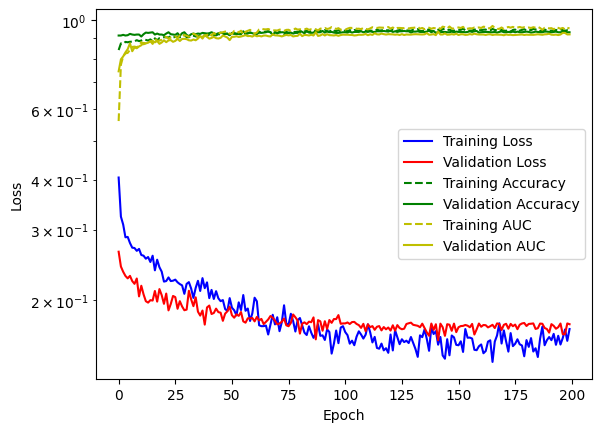

Epoch:0, Training_loss:0.4046, Training_acc:0.8417, Training_auc:0.5597, Training_bal_acc:0.4971, Eval_loss:0.2642, Eval_acc:0.9149, Eval_auc:0.7448, Eval_bal_acc:0.5000
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
Epoch:20, Training_loss:0.2225, Training_acc:0.9062, Training_auc:0.9039, Training_bal_acc:0.6980, Eval_loss:0.1958, Eval_acc:0.9167, Eval_auc:0.8903, Eval_bal_acc:0.6398
saving best...
saving best...
Epoch:40, Training_loss:0.2023, Training_acc:0.9221, Training_auc:0.9281, Training_bal_acc:0.7854, Eval_loss:0.1939, Eval_acc:0.9271, Eval_auc:0.8988, Eval_bal_acc:0.7103
Epoch:60, Training_loss:0.2028, Training_acc:0.9183, Training_auc:0.9250, Training_bal_acc:0.7665, Eval_loss:0.1770, Eval_acc:0.9236, Eval_auc:0.9166, Eval_bal_acc:0.7084
Epoch:80, Training_loss:0.1805, Training_acc:0.9295, Training_auc:0.9482, Training_bal_acc:0.8312, Eval_loss:0.1650, Eval_acc:0.9410, Eval_auc:0.9248, Eval_bal_acc:0.7837
Epoch:100, Training_loss:0

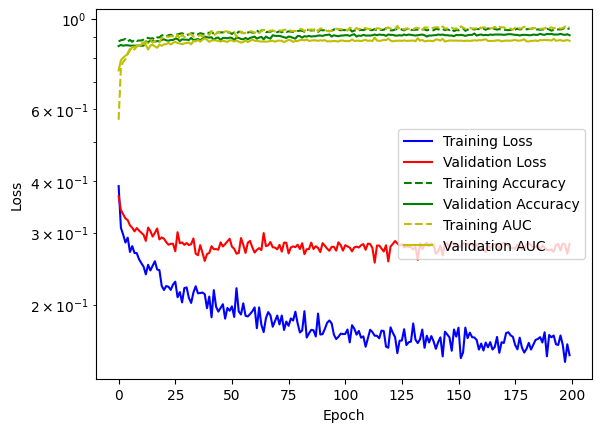

Epoch:0, Training_loss:0.3897, Training_acc:0.8800, Training_auc:0.5662, Training_bal_acc:0.5035, Eval_loss:0.3680, Eval_acc:0.8576, Eval_auc:0.7475, Eval_bal_acc:0.5000
saving best...
saving best...
saving best...
Epoch:20, Training_loss:0.2171, Training_acc:0.9125, Training_auc:0.8982, Training_bal_acc:0.6715, Eval_loss:0.2898, Eval_acc:0.8906, Eval_auc:0.8657, Eval_bal_acc:0.6864
saving best...
saving best...
Epoch:40, Training_loss:0.2093, Training_acc:0.9232, Training_auc:0.9130, Training_bal_acc:0.7404, Eval_loss:0.2675, Eval_acc:0.8993, Eval_auc:0.8780, Eval_bal_acc:0.7423
saving best...
saving best...
Epoch:60, Training_loss:0.1969, Training_acc:0.9245, Training_auc:0.9227, Training_bal_acc:0.7496, Eval_loss:0.2681, Eval_acc:0.9045, Eval_auc:0.8835, Eval_bal_acc:0.7424
Epoch:80, Training_loss:0.1709, Training_acc:0.9356, Training_auc:0.9441, Training_bal_acc:0.7927, Eval_loss:0.2735, Eval_acc:0.9062, Eval_auc:0.8865, Eval_bal_acc:0.7168
Epoch:100, Training_loss:0.1696, Training

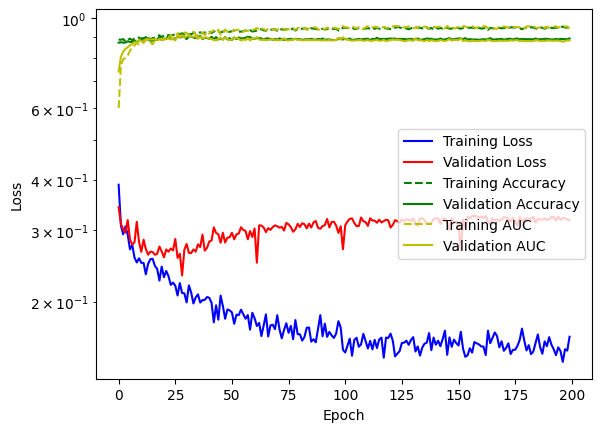

Epoch:0, Training_loss:0.3886, Training_acc:0.8870, Training_auc:0.6014, Training_bal_acc:0.5015, Eval_loss:0.3420, Eval_acc:0.8715, Eval_auc:0.7396, Eval_bal_acc:0.5000
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
Epoch:20, Training_loss:0.2298, Training_acc:0.9091, Training_auc:0.8865, Training_bal_acc:0.6524, Eval_loss:0.2573, Eval_acc:0.8924, Eval_auc:0.8892, Eval_bal_acc:0.6807
saving best...
Epoch:40, Training_loss:0.2045, Training_acc:0.9245, Training_auc:0.9169, Training_bal_acc:0.7520, Eval_loss:0.2814, Eval_acc:0.8906, Eval_auc:0.8918, Eval_bal_acc:0.6856
Epoch:60, Training_loss:0.1820, Training_acc:0.9303, Training_auc:0.9397, Training_bal_acc:0.7926, Eval_loss:0.3030, Eval_acc:0.8906, Eval_auc:0.8913, Eval_bal_acc:0.6838
Epoch:80, Training_loss:0.1661, Training_acc:0.9421, Training_auc:0.9464, Training_bal_acc:0.8271, Eval_loss:0.3056, Eval_acc:0.8889, Eval_auc:0.8867, Eval_bal_acc:0.7022
Epoch:100, Training_loss:0

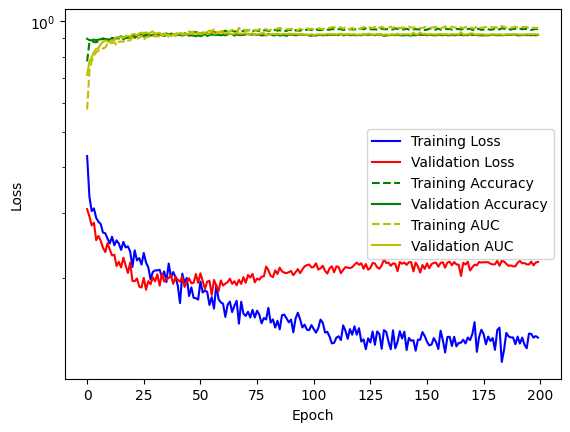

Epoch:0, Training_loss:0.4295, Training_acc:0.7778, Training_auc:0.5749, Training_bal_acc:0.5014, Eval_loss:0.3076, Eval_acc:0.8976, Eval_auc:0.7149, Eval_bal_acc:0.5000
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
Epoch:20, Training_loss:0.2138, Training_acc:0.9162, Training_auc:0.9048, Training_bal_acc:0.7019, Eval_loss:0.1959, Eval_acc:0.9167, Eval_auc:0.9235, Eval_bal_acc:0.6589
saving best...
saving best...
Epoch:40, Training_loss:0.1904, Training_acc:0.9276, Training_auc:0.9274, Training_bal_acc:0.7443, Eval_loss:0.1974, Eval_acc:0.9184, Eval_auc:0.9247, Eval_bal_acc:0.7015
saving best...
Epoch:60, Training_loss:0.1698, Training_acc:0.9364, Training_auc:0.9432, Training_bal_acc:0.7995, Eval_loss:0.1902, Eval_acc:0.9201, Eval_auc:0.9304, Eval_bal_acc:0.7602
saving best...
saving best...
Epoch:80, Training_loss:0.1654, Training_acc:0.9407, Training_auc:0.9448, Training_bal_acc:0.8168, Eval_loss:0.2096, Eval_acc:0.9236, Eva

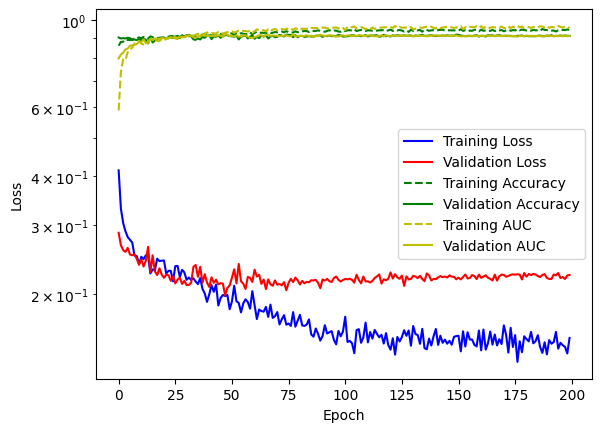

Epoch:0, Training_loss:0.4134, Training_acc:0.8605, Training_auc:0.5880, Training_bal_acc:0.5010, Eval_loss:0.2864, Eval_acc:0.9028, Eval_auc:0.7985, Eval_bal_acc:0.5000
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
Epoch:20, Training_loss:0.2435, Training_acc:0.9002, Training_auc:0.8857, Training_bal_acc:0.6756, Eval_loss:0.2198, Eval_acc:0.9028, Eval_auc:0.8989, Eval_bal_acc:0.6305
saving best...
Epoch:40, Training_loss:0.1995, Training_acc:0.9211, Training_auc:0.9233, Training_bal_acc:0.7205, Eval_loss:0.2083, Eval_acc:0.9149, Eval_auc:0.9124, Eval_bal_acc:0.6541
saving best...
Epoch:60, Training_loss:0.1868, Training_acc:0.9270, Training_auc:0.9369, Training_bal_acc:0.7591, Eval_loss:0.2306, Eval_acc:0.8958, Eval_auc:0.9041, Eval_bal_acc:0.7430
Epoch:80, Training_loss:0.1768, Training_acc:0.9333, Training_auc:0.9422, Training_bal_acc:0.7930, Eval_loss:0.2113, Eval_acc:0.9115, Eva

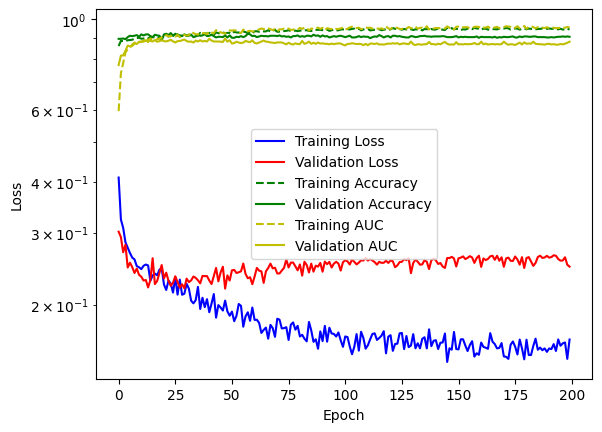

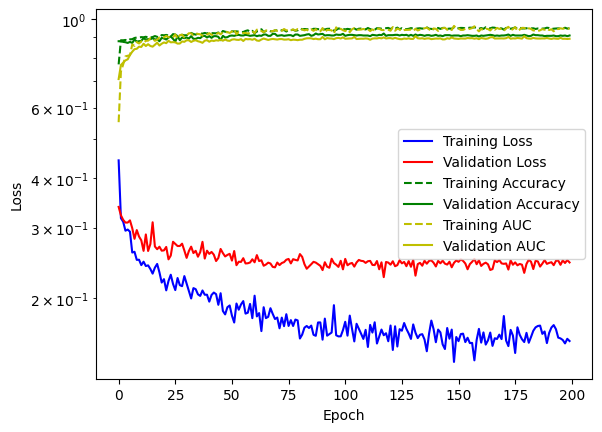

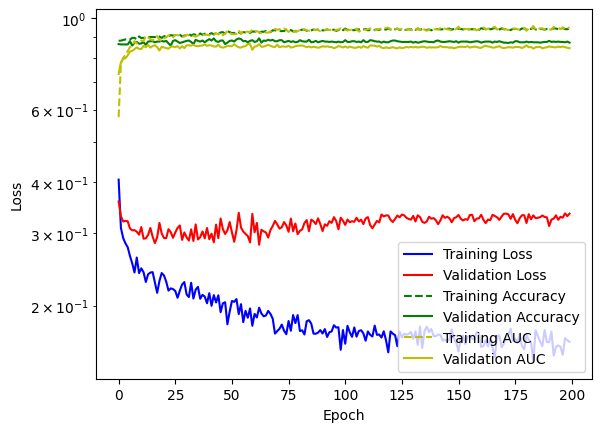

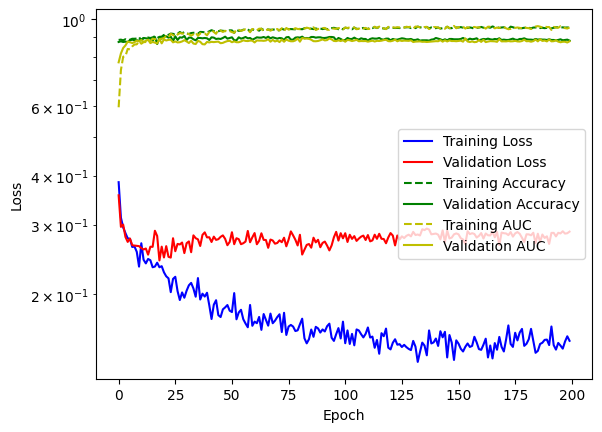

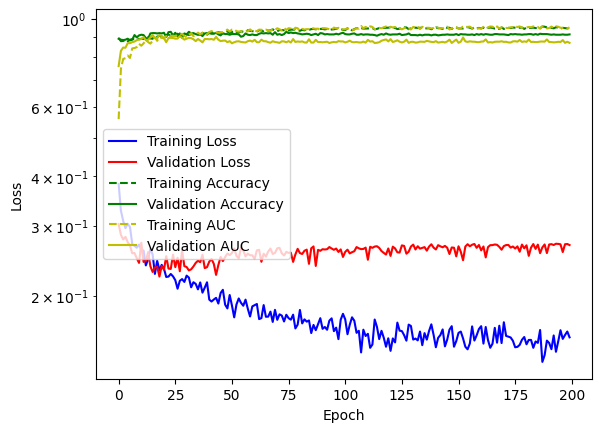

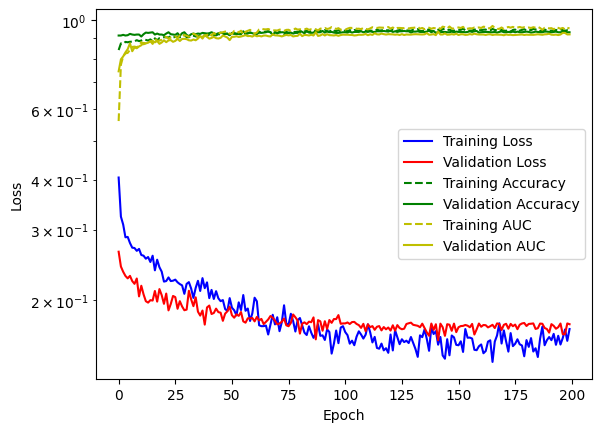

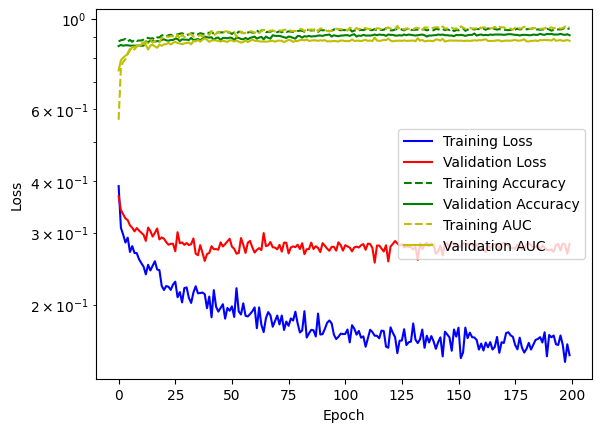

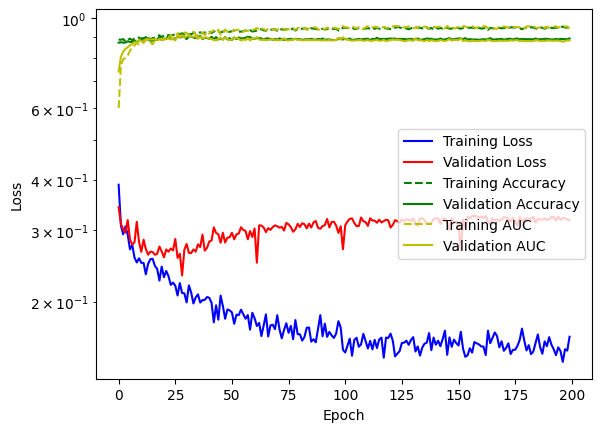

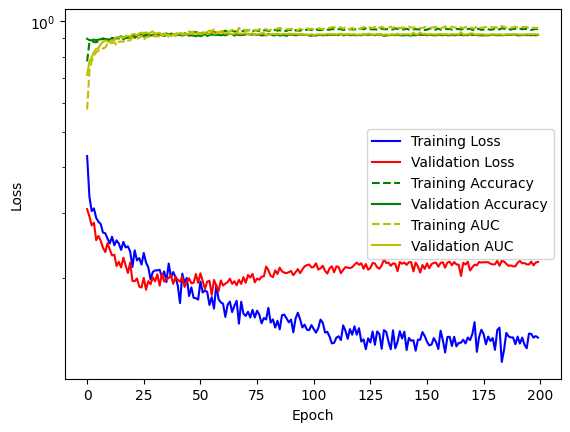

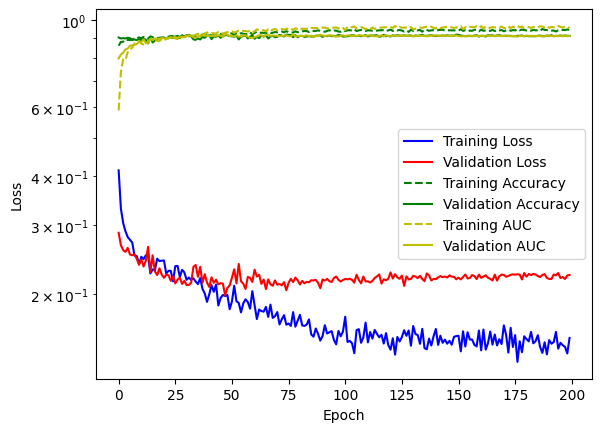

In [ ]:
batch_size = 64

do = 0.2
num_layer = 2
num_hidden = 64
lr = 0.001

best_acc_list = []
best_auc_list = []
best_bal_acc_list = []

for i, (train_index, test_index) in enumerate(skf.split(np.zeros(len(train_class_label)), train_class_label)):
    trainfold = train_set[train_index]
    valfold = train_set[test_index]
    train_sampler = ImbalancedSampler(torch.tensor([0 if e==[1,0] else 1 for e in trainfold.y.view(-1,2)], dtype=torch.long))
    train_dataloader = DataLoader(trainfold, batch_size=batch_size, sampler=train_sampler, drop_last=True, worker_init_fn=seed_worker,generator=g)
    val_dataloader = DataLoader(valfold, batch_size=batch_size, shuffle=True, drop_last=True, worker_init_fn=seed_worker,generator=g)

    model = MPNNModel(node_dim=trainfold[0].x.size(1), edge_dim=trainfold[0].edge_attr.size(1), hidden_dim=num_hidden, num_layers=num_layer, dropout=do).to(device)

    trainer = Trainer(model=model,
                      train_loader=train_dataloader,
                      val_loader=val_dataloader,
                      test_loader=None,
                      device=device,
                      save_dir=os.path.join(os.getcwd(),'models/MPNN/cross-val'),
                      save_name='MPNN_' + str(i))
    train_params = {'num_epochs': 200,
                    'num_early_stop': 0,
                    'step': 20,
                    'gamma': 0.5}
                    
    optimizer_params = {'lr': lr,
                        'weight_decay': 1e-5}
                    
    best_eval_acc, best_eval_auc, best_eval_bal_acc = trainer.train(train_params=train_params, optimizer_params=optimizer_params, verbose=True,)
    best_acc_list.append(best_eval_acc)
    best_auc_list.append(best_eval_auc)
    best_bal_acc_list.append(best_eval_bal_acc)

In [19]:
best_acc_list =[0.8872, 0.9184, 0.8819, 0.8941, 0.9080, 0.9115, 0.8924, 0.8889, 0.9219, 0.9097]
best_auc_list =[0.8871, 0.8918, 0.8560, 0.8917, 0.8783, 0.8902, 0.8745, 0.9029, 0.9307, 0.9141]
best_bal_acc_list =[0.7897, 0.7840, 0.7293, 0.7459, 0.8248, 0.8002, 0.8031, 0.8056, 0.8188, 0.7781]

print(f'The model achieves accuracy={np.mean(best_acc_list):.4f}±{np.std(best_acc_list):.4f}, AUC={np.mean(best_auc_list):.4f}±{np.std(best_auc_list):.4f}' 
      f' and balanced accuracy={np.mean(best_bal_acc_list):.4f}±{np.std(best_bal_acc_list):.4f}')

The model achieves accuracy=0.9014±0.0134, AUC=0.8917±0.0198 and balanced accuracy=0.7880±0.0289


## 3. Evaluate Test Set
<a id='test'></a>

As a last step we train the model one last time on a radom subset of the training data (keeping 15% for validation) and then evaluate the test set with the model and compute the confusion matrix, the ROC curve and the Precision-Recall curve

In [20]:
batch_size = 64

do = 0.2
num_layer = 2
num_hidden = 64
lr = 0.001

train_final, _ , val_final = random_split_dataset(train_set, frac_train=0.85, frac_val=0.0, frac_test=0.15)

train_sampler = ImbalancedSampler(torch.tensor([0 if e==[1,0] else 1 for e in train_final.y.view(-1,2)], dtype=torch.long))
train_dataloader = DataLoader(train_final, batch_size=batch_size, sampler=train_sampler, drop_last=True, worker_init_fn=seed_worker,generator=g)
val_dataloader = DataLoader(val_final, batch_size=batch_size, shuffle=True, drop_last=True, worker_init_fn=seed_worker,generator=g)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=True, drop_last=True, worker_init_fn=seed_worker,generator=g)

model = MPNNModel(node_dim=train_final[0].x.size(1), edge_dim=train_final[0].edge_attr.size(1), hidden_dim=num_hidden, num_layers=num_layer, dropout=do).to(device)

trainer = Trainer(model=model,
                  train_loader=train_dataloader,
                  val_loader=val_dataloader,
                  test_loader=test_dataloader,
                  device=device,
                  save_dir=os.path.join(os.getcwd(),'models/final'),
                  save_name='MPNN')

train_params = {'num_epochs': 200,
                'num_early_stop': 0,
                'step': 20,
                'gamma': 0.5}
                    
optimizer_params = {'lr': lr,
                    'weight_decay': 1e-5}

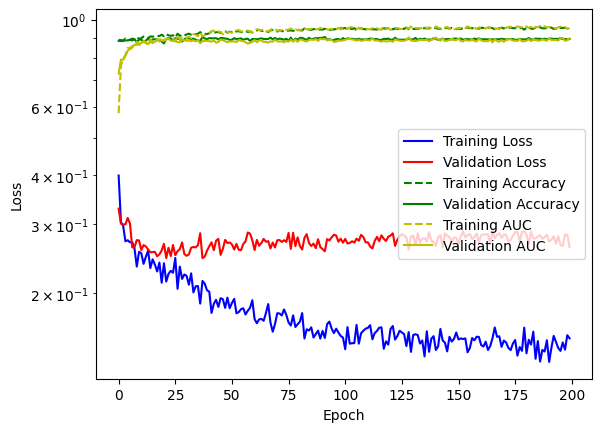

Epoch:0, Training_loss:0.3997, Training_acc:0.8882, Training_auc:0.5772, Training_bal_acc:0.5000, Eval_loss:0.3290, Eval_acc:0.8834, Eval_auc:0.7287, Eval_bal_acc:0.5000
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
Epoch:20, Training_loss:0.2385, Training_acc:0.9077, Training_auc:0.8858, Training_bal_acc:0.6954, Eval_loss:0.2675, Eval_acc:0.8702, Eval_auc:0.8826, Eval_bal_acc:0.7429
saving best...
saving best...
Epoch:40, Training_loss:0.2018, Training_acc:0.9235, Training_auc:0.9208, Training_bal_acc:0.7584, Eval_loss:0.2636, Eval_acc:0.8978, Eval_auc:0.8818, Eval_bal_acc:0.6987
Epoch:60, Training_loss:0.1717, Training_acc:0.9363, Training_auc:0.9424, Training_bal_acc:0.8021, Eval_loss:0.2578, Eval_acc:0.8930, Eval_auc:0.8876, Eval_bal_acc:0.7448
Epoch:80, Training_loss:0.1691, Training_acc:0.9401, Training_auc:0.9431, Training_bal_acc:0.8225, Eval_loss:0.2639, Eval_acc:0.8990, Eval_auc:0.8898, Eval_bal_acc:0.7483
Epoch:100, Training_loss:0

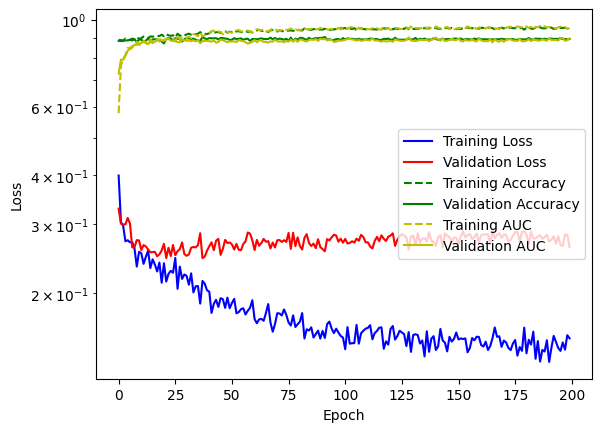

In [ ]:
best_eval_acc, best_eval_auc, best_eval_bal_acc = trainer.train(train_params=train_params, optimizer_params=optimizer_params, verbose=True,)


Load best model and evaluate test set

In [22]:
trainer.load_model()

test_loss, test_acc, test_auc, test_bal_acc ,preds, pred_probs, labels = trainer.test()

Test loss: 0.2799, test acc 0.8750, test_auc 0.8812, test_bal_acc 0.7363


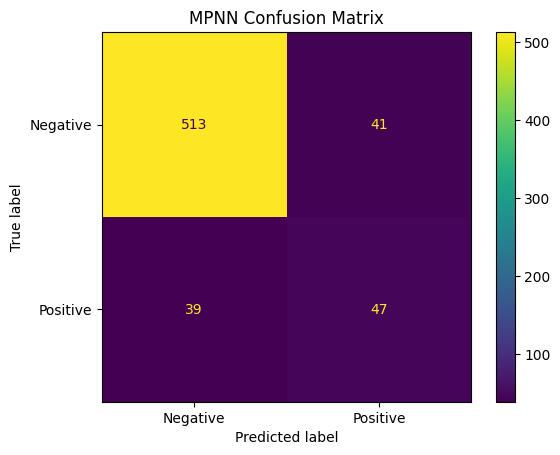

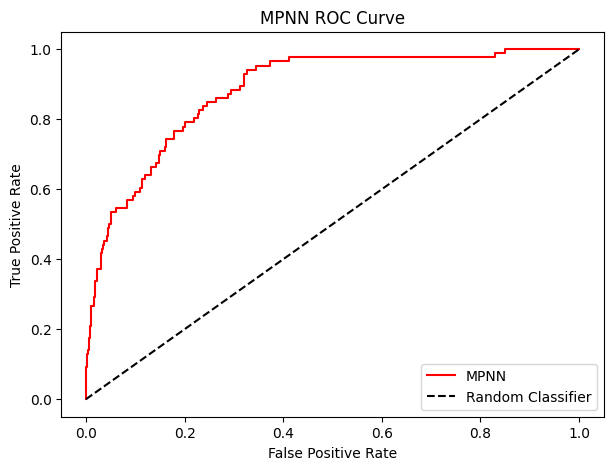

In [23]:
# Confusion matrix
c_matrix = confusion_matrix(labels.numpy(), preds)
disp = ConfusionMatrixDisplay(
    c_matrix, display_labels=["Negative","Positive"]
)
disp.plot() 
plt.title("MPNN Confusion Matrix") 
plt.savefig('MPNN_confusion.pdf')
plt.show()

# AUC by class
y_true_bin = label_binarize(labels.numpy(), classes=np.arange(2))
plt.figure(figsize=(7,5))
fpr, tpr, _ = roc_curve(y_true_bin[:, 0], pred_probs.numpy())
plt.plot(fpr, tpr, "r-", label="MPNN")
plt.plot([0,1], [0,1], "k--", label="Random Classifier")
plt.xlabel("False Positive Rate") 
plt.ylabel("True Positive Rate")
plt.title("MPNN ROC Curve") 
plt.legend() 
plt.savefig('MPNN_ROC.pdf')
plt.show()

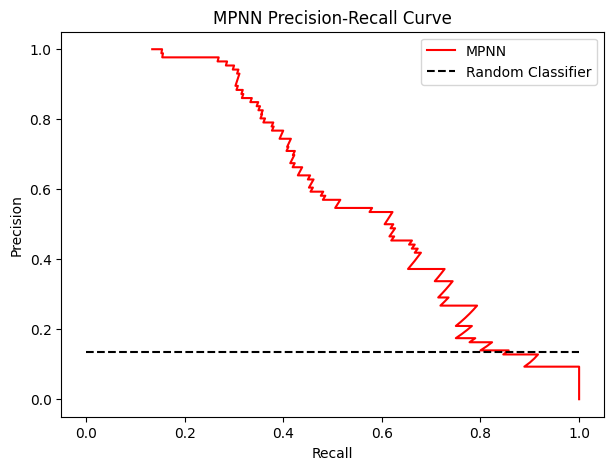

In [24]:
# AUC by class
pos_ratio = y_true_bin.sum().item()/len(y_true_bin)
y_true_bin = label_binarize(labels.numpy(), classes=np.arange(2))
plt.figure(figsize=(7,5))
fpr, tpr, _ = precision_recall_curve(y_true_bin[:, 0], pred_probs.numpy())
plt.plot(fpr, tpr, "r-", label="MPNN")
plt.plot([0,1], [pos_ratio,pos_ratio], "k--", label="Random Classifier")
plt.xlabel("Recall") 
plt.ylabel("Precision")
plt.title("MPNN Precision-Recall Curve") 
plt.legend() 
plt.savefig('MPNN_PR_curve.pdf')
plt.show()